In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx
import itertools
import re

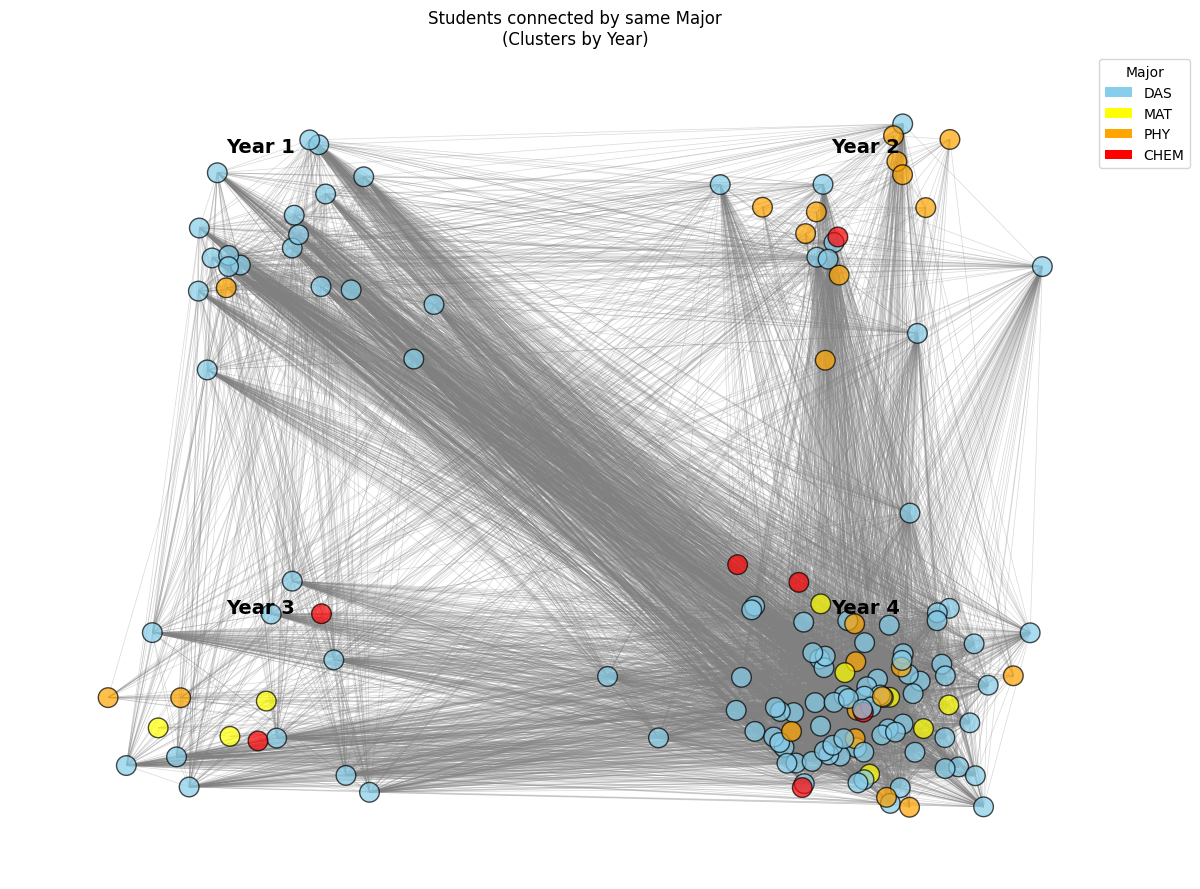

In [166]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major'])

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'])

# connect students of same major
for i, j in itertools.combinations(df.index, 2):
    if df.loc[i, 'Major'] == df.loc[j, 'Major']:
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']  # your palette
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {
    1: (-3, 3),
    2: (3, 3),
    3: (-3, -3),
    4: (3, -3)
}

coords = []
colors = []
for idx, row in df.iterrows():
    year = row['Year_num']
    major = row['Major']
    cx, cy = cluster_centers.get(year, (0,0))

    # jitter point around center
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

    colors.append(color_map.get(major,'gray'))

coords = np.array(coords)

# dict of positions for NetworkX
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

# 1. Draw edges first (thin grey lines)
nx.draw_networkx_edges(
    G, pos,
    edge_color='gray', alpha=0.3, width=0.5
)

# 2. Draw nodes on top (colored by major)
nx.draw_networkx_nodes(
    G, pos,
    node_color=colors,
    node_size=200,
    edgecolors='k',
    alpha=0.7
)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend for majors
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors]
plt.legend(handles=legend_elements, title="Major", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by same Major\n(Clusters by Year)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [167]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
   Node    Degree  Betweenness  Closeness  Eigenvector  avg_centrality
0     0  0.736486          0.0   0.736486     0.095346         0.39208
1    86  0.736486          0.0   0.736486     0.095346         0.39208
2    98  0.736486          0.0   0.736486     0.095346         0.39208
3    97  0.736486          0.0   0.736486     0.095346         0.39208
4    96  0.736486          0.0   0.736486     0.095346         0.39208

Least important nodes (lowest centrality):
   Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0   101  0.040541          0.0   0.040541  4.029407e-10         0.02027
1    80  0.040541          0.0   0.040541  4.029407e-10         0.02027
2    64  0.040541          0.0   0.040541  4.029407e-10         0.02027
3    39  0.040541          0.0   0.040541  4.029407e-10         0.02027
4   121  0.040541          0.0   0.040541  4.029407e-10         0.02027


In [168]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")



--- Degree Centrality ---
Highest: Node=0, Value=0.7365
Lowest: Node=39, Value=0.0405

--- Betweenness Centrality ---
Highest: Node=0, Value=0.0000
Lowest: Node=0, Value=0.0000

--- Closeness Centrality ---
Highest: Node=0, Value=0.7365
Lowest: Node=39, Value=0.0405

--- Eigenvector Centrality ---
Highest: Node=0, Value=0.0953
Lowest: Node=39, Value=0.0000


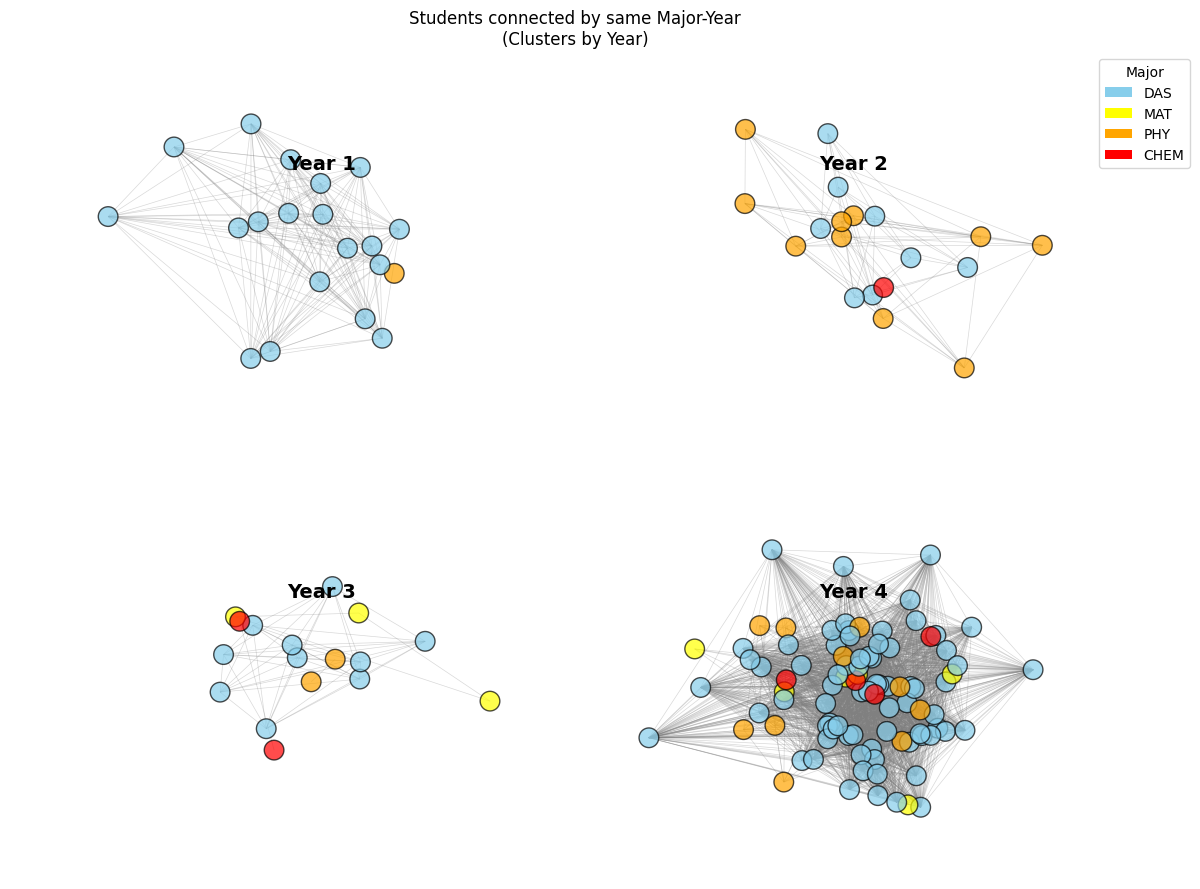

In [169]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major'])

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'])

# connect students of same yr having same major
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and (df.loc[i, 'Major'] == df.loc[j, 'Major']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']  # your palette
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {
    1: (-3, 3),
    2: (3, 3),
    3: (-3, -3),
    4: (3, -3)
}

coords = []
colors = []
for idx, row in df.iterrows():
    year = row['Year_num']
    major = row['Major']
    cx, cy = cluster_centers.get(year, (0,0))

    # jitter point around center
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

    colors.append(color_map.get(major,'gray'))

coords = np.array(coords)

# dict of positions for NetworkX
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

# 1. Draw edges first (thin grey lines)
nx.draw_networkx_edges(
    G, pos,
    edge_color='gray', alpha=0.3, width=0.5
)

# 2. Draw nodes on top (colored by major)
nx.draw_networkx_nodes(
    G, pos,
    node_color=colors,
    node_size=200,
    edgecolors='k',
    alpha = 0.7
)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend for majors
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors]
plt.legend(handles=legend_elements, title="Major", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by same Major-Year\n(Clusters by Year)")
plt.axis('off')
plt.tight_layout()
plt.show()


In [170]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
   Node    Degree  Betweenness  Closeness  Eigenvector  avg_centrality
0     0  0.486486          0.0   0.486486     0.117041        0.272504
1   105  0.486486          0.0   0.486486     0.117041        0.272504
2    83  0.486486          0.0   0.486486     0.117041        0.272504
3    82  0.486486          0.0   0.486486     0.117041        0.272504
4    81  0.486486          0.0   0.486486     0.117041        0.272504

Least important nodes (lowest centrality):
   Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0    21  0.000000          0.0   0.000000  1.451295e-16    3.628237e-17
1   101  0.000000          0.0   0.000000  1.451295e-16    3.628237e-17
2    84  0.006757          0.0   0.006757  3.715315e-14    3.378378e-03
3   130  0.006757          0.0   0.006757  3.715315e-14    3.378378e-03
4    80  0.006757          0.0   0.006757  3.715315e-14    3.378378e-03


In [171]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")



--- Degree Centrality ---
Highest: Node=0, Value=0.4865
Lowest: Node=21, Value=0.0000

--- Betweenness Centrality ---
Highest: Node=0, Value=0.0000
Lowest: Node=0, Value=0.0000

--- Closeness Centrality ---
Highest: Node=0, Value=0.4865
Lowest: Node=21, Value=0.0000

--- Eigenvector Centrality ---
Highest: Node=0, Value=0.1170
Lowest: Node=21, Value=0.0000


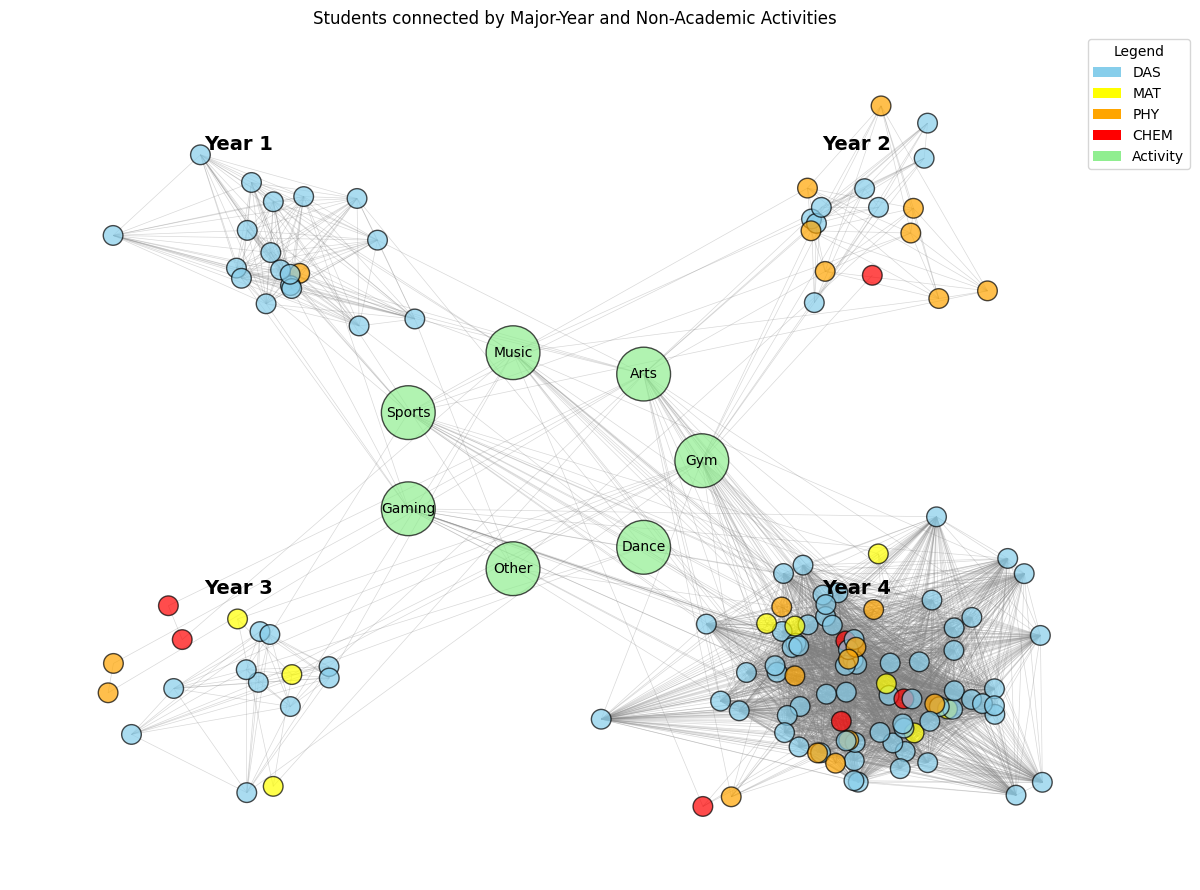

In [172]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major','nonacademic_activities'])  # assuming column name

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students with same major in the same year
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and (df.loc[i, 'Major'] == df.loc[j, 'Major']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']  # your palette
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {
    1: (-3, 3),
    2: (3, 3),
    3: (-3, -3),
    4: (3, -3)
}

coords = []
colors = []
for idx, row in df.iterrows():
    year = row['Year_num']
    major = row['Major']
    cx, cy = cluster_centers.get(year, (0,0))

    # jitter point around center
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

    colors.append(color_map.get(major,'gray'))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Non-academic activities as nodes
# -------------------------------
activities = {
    'Gym': 34, 'Arts': 32, 'Music': 22, 'Sports': 22,
    'Gaming': 19, 'Other': 5, 'Dance': 5
}

# Place activities in a circle at the center (0,0)
num_activities = len(activities)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_activities, endpoint=False)
activity_pos = {}
for i, (act, count) in enumerate(activities.items()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    activity_pos[act] = (x, y)
    G.add_node(act, type='activity')

# Connect students to their activities
for idx, row in df.iterrows():
    student_activities = str(row['nonacademic_activities']).split(',')  # adjust separator
    for act in student_activities:
        act = act.strip()
        if act in activities:
            G.add_edge(idx, act)

# Merge positions
pos.update(activity_pos)

# -------------------------------
# Node colors: students by major, activities by color
# -------------------------------
activity_colors = 'lightgreen'
node_colors = []
node_sizes = []  # NEW: size list for each node
for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)  # smaller size for students
    else:
        node_colors.append(activity_colors)
        node_sizes.append(1500)  # larger size for activities

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k',alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='activity'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + [Patch(facecolor=activity_colors, label='Activity')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Major-Year and Non-Academic Activities")
plt.axis('off')
plt.tight_layout()
plt.show()



In [6]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
   Node    Degree  Betweenness  Closeness  Eigenvector  avg_centrality
0   116  0.310811          0.0   0.310811     0.145865        0.191872
1    25  0.310811          0.0   0.310811     0.145865        0.191872
2    27  0.310811          0.0   0.310811     0.145865        0.191872
3    28  0.310811          0.0   0.310811     0.145865        0.191872
4    76  0.310811          0.0   0.310811     0.145865        0.191872

Least important nodes (lowest centrality):
   Node  Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0    62     0.0          0.0        0.0  1.255385e-21    3.138461e-22
1    80     0.0          0.0        0.0  1.255385e-21    3.138461e-22
2   101     0.0          0.0        0.0  1.255385e-21    3.138461e-22
3    64     0.0          0.0        0.0  1.255385e-21    3.138461e-22
4   108     0.0          0.0        0.0  1.255385e-21    3.138461e-22


In [174]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")



--- Degree Centrality ---
Highest: Node=0, Value=0.4552
Lowest: Node=21, Value=0.0069

--- Betweenness Centrality ---
Highest: Node=Arts, Value=0.1953
Lowest: Node=21, Value=0.0000

--- Closeness Centrality ---
Highest: Node=Arts, Value=0.5254
Lowest: Node=101, Value=0.3152

--- Eigenvector Centrality ---
Highest: Node=16, Value=0.1230
Lowest: Node=65, Value=0.0001


In [175]:
# Replace the specific Info_sharing string with "Inperson"
df['Info_sharing'] = df['Info_sharing'].replace(
    'Inform them in person as well as notify them through WhatsApp also.', 
    'Inperson'
)

# Verify replacement
print(df['Info_sharing'].value_counts())


Info_sharing
WhatsApp     133
Instagram      4
Inperson       1
Discord        1
Name: count, dtype: int64


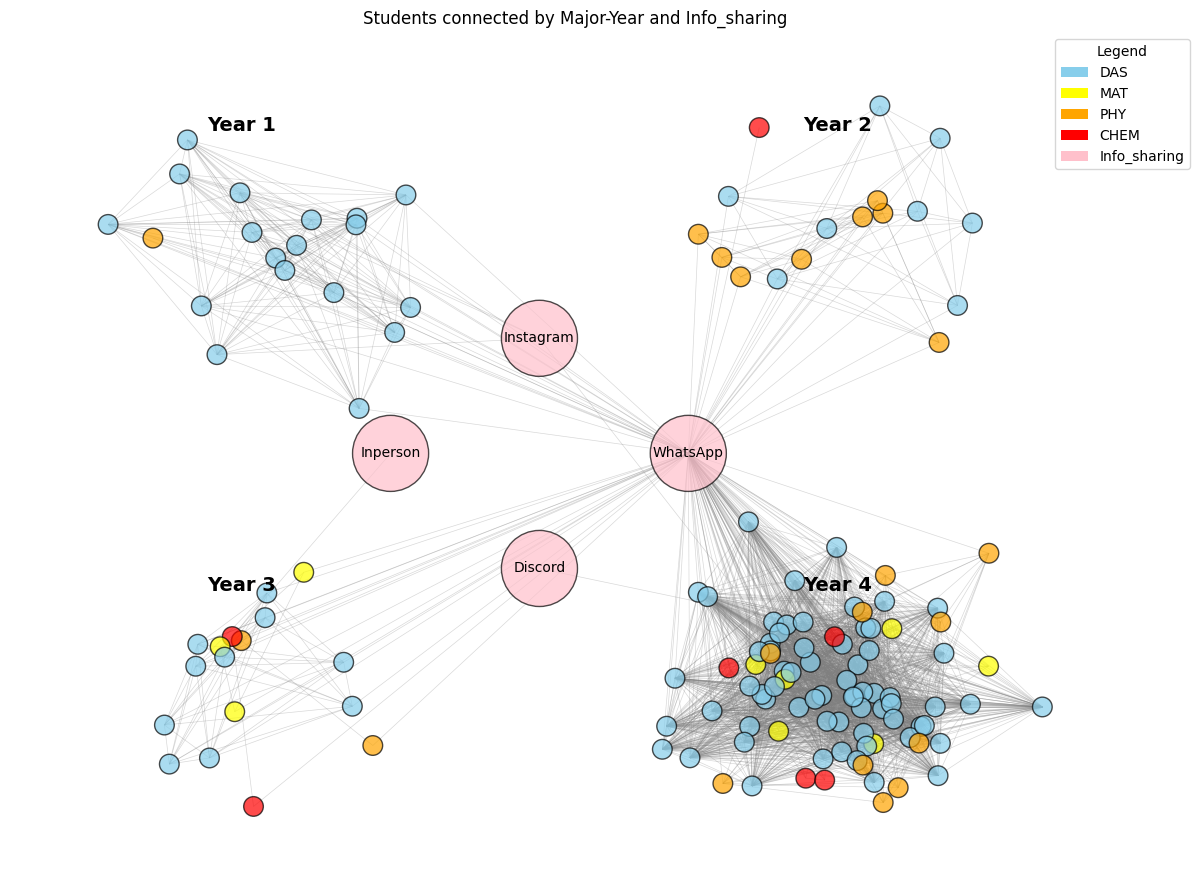

In [176]:
df = df.dropna(subset=['Year','Major','Info_sharing'])  # column name for info sharing

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students with same major in the same year
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and (df.loc[i, 'Major'] == df.loc[j, 'Major']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']  # your palette
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {
    1: (-3, 3),
    2: (3, 3),
    3: (-3, -3),
    4: (3, -3)
}

coords = []
for idx, row in df.iterrows():
    year = row['Year_num']
    cx, cy = cluster_centers.get(year, (0,0))
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Info_sharing nodes
# -------------------------------
info_counts = df['Info_sharing'].value_counts().to_dict()
num_info = len(info_counts)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_info, endpoint=False)
info_pos = {}

for i, info in enumerate(info_counts.keys()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    info_pos[info] = (x, y)
    G.add_node(info, type='info')

# Connect students to their Info_sharing methods
for idx, row in df.iterrows():
    student_info = str(row['Info_sharing']).split(',')  # split in case multiple
    for info in student_info:
        info = info.strip()
        if info in info_counts:
            G.add_edge(idx, info)

# Merge positions
pos.update(info_pos)

# -------------------------------
# Node colors and sizes
# -------------------------------
node_colors = []
node_sizes = []

for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)
    else:  # info nodes
        node_colors.append('pink')
        node_sizes.append(3000)

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='info'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + \
                  [Patch(facecolor='pink', label='Info_sharing')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Major-Year and Info_sharing")
plt.axis('off')
plt.tight_layout()
plt.show()

In [177]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")


Most important nodes (highest centrality):
       Node    Degree  Betweenness  Closeness  Eigenvector  avg_centrality
0  WhatsApp  0.936620     0.735823   0.922078     0.120794        0.678829
1         0  0.464789     0.000388   0.633929     0.122224        0.305332
2        72  0.464789     0.000388   0.633929     0.122224        0.305332
3        83  0.464789     0.000388   0.633929     0.122224        0.305332
4        81  0.464789     0.000388   0.633929     0.122224        0.305332

Least important nodes (lowest centrality):
        Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0   Inperson  0.007042     0.000000   0.248687  4.214628e-07        0.063932
1    Discord  0.007042     0.000000   0.325688  1.826083e-03        0.083639
2         80  0.014085     0.014085   0.330233  2.778292e-05        0.089607
3  Instagram  0.028169     0.002165   0.357683  1.852817e-03        0.097467
4        101  0.007042     0.000000   0.481356  1.831416e-03        0.122557



In [178]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")



--- Degree Centrality ---
Highest: Node=WhatsApp, Value=0.9366
Lowest: Node=21, Value=0.0070

--- Betweenness Centrality ---
Highest: Node=WhatsApp, Value=0.7358
Lowest: Node=2, Value=0.0000

--- Closeness Centrality ---
Highest: Node=WhatsApp, Value=0.9221
Lowest: Node=Inperson, Value=0.2487

--- Eigenvector Centrality ---
Highest: Node=0, Value=0.1222
Lowest: Node=Inperson, Value=0.0000


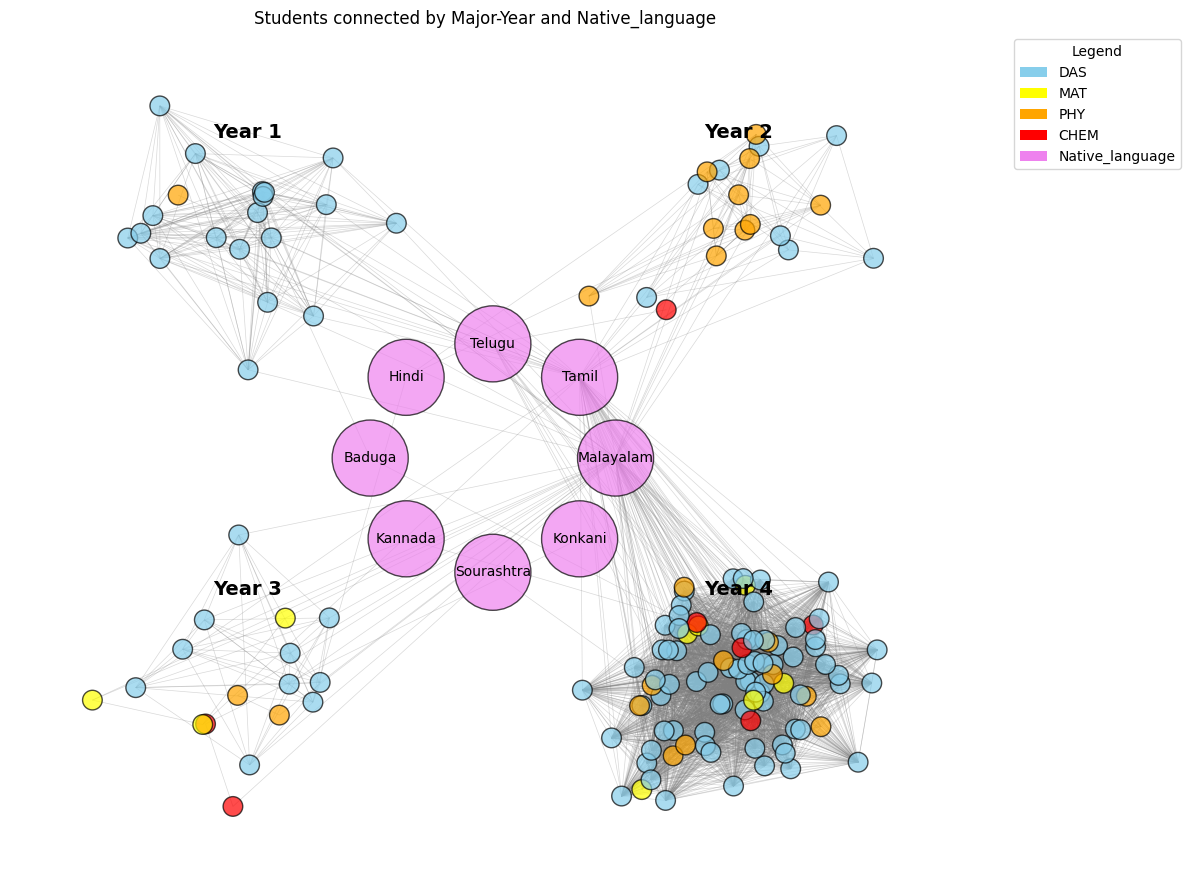

In [179]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major','Native_language'])  # column name

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students with same major in the same year
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and (df.loc[i, 'Major'] == df.loc[j, 'Major']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']  # your palette
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {
    1: (-3, 3),
    2: (3, 3),
    3: (-3, -3),
    4: (3, -3)
}

coords = []
for idx, row in df.iterrows():
    year = row['Year_num']
    cx, cy = cluster_centers.get(year, (0,0))
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Native_language nodes
# -------------------------------
language_counts = df['Native_language'].value_counts().to_dict()
num_languages = len(language_counts)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_languages, endpoint=False)
language_pos = {}

for i, lang in enumerate(language_counts.keys()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    language_pos[lang] = (x, y)
    G.add_node(lang, type='language')

# Connect students to their native language
for idx, row in df.iterrows():
    lang = str(row['Native_language']).strip()
    if lang in language_counts:
        G.add_edge(idx, lang)

# Merge positions
pos.update(language_pos)

# -------------------------------
# Node colors and sizes
# -------------------------------
node_colors = []
node_sizes = []

for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)
    elif G.nodes[n].get('type') == 'language':
        node_colors.append('violet')
        node_sizes.append(3000)

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='language'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + \
                  [Patch(facecolor='violet', label='Native_language')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Major-Year and Native_language")
plt.axis('off')
plt.tight_layout()
plt.show()

In [180]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
        Node    Degree  Betweenness  Closeness  Eigenvector  avg_centrality
0  Malayalam  0.448718     0.452622   0.616601     0.043947        0.390472
1      Tamil  0.391026     0.245248   0.557143     0.056845        0.312565
2          0  0.467949     0.006853   0.565217     0.116712        0.289183
3        110  0.467949     0.006853   0.565217     0.116712        0.289183
4         26  0.467949     0.006853   0.565217     0.116712        0.289183

Least important nodes (lowest centrality):
      Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0  Konkani  0.006410     0.000000   0.219101  1.159902e-07        0.056378
1      101  0.006410     0.000000   0.266212  1.776627e-04        0.068200
2    Hindi  0.019231     0.000619   0.257426  3.461245e-06        0.069320
3       80  0.012821     0.012821   0.280072  8.391787e-06        0.076430
4  Kannada  0.006410     0.000000   0.325000  1.604392e-03        0.083254


In [181]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")


--- Degree Centrality ---
Highest: Node=0, Value=0.4679
Lowest: Node=21, Value=0.0064

--- Betweenness Centrality ---
Highest: Node=Malayalam, Value=0.4526
Lowest: Node=21, Value=0.0000

--- Closeness Centrality ---
Highest: Node=Malayalam, Value=0.6166
Lowest: Node=Konkani, Value=0.2191

--- Eigenvector Centrality ---
Highest: Node=12, Value=0.1169
Lowest: Node=Konkani, Value=0.0000


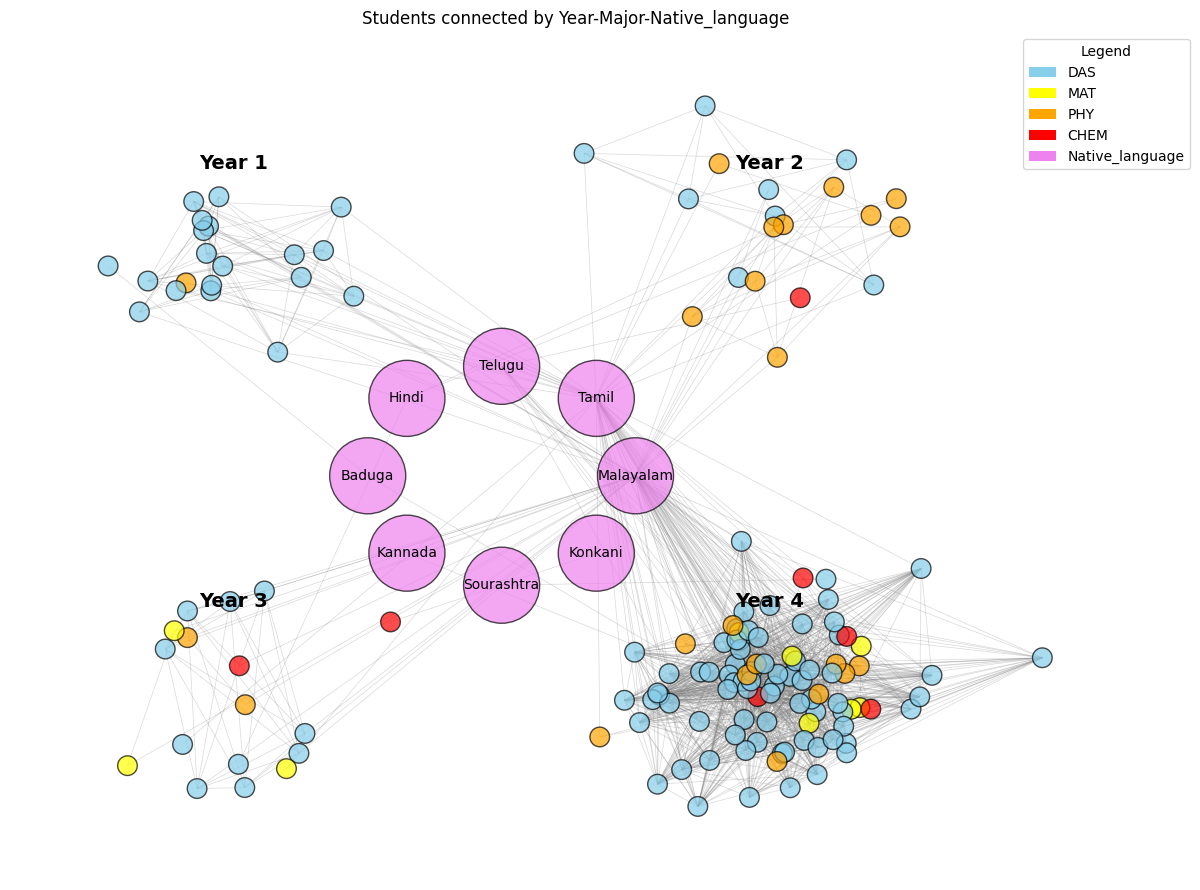

In [182]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major','Native_language'])

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students only if:
# same Year AND same Major AND same Native_language
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and \
       (df.loc[i, 'Major'] == df.loc[j, 'Major']) and \
       (df.loc[i, 'Native_language'] == df.loc[j, 'Native_language']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {1: (-3, 3), 2: (3, 3), 3: (-3, -3), 4: (3, -3)}
coords = []

for idx, row in df.iterrows():
    year = row['Year_num']
    cx, cy = cluster_centers.get(year, (0,0))
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Native_language nodes
# -------------------------------
language_counts = df['Native_language'].value_counts().to_dict()
num_languages = len(language_counts)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_languages, endpoint=False)
language_pos = {}

for i, lang in enumerate(language_counts.keys()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    language_pos[lang] = (x, y)
    G.add_node(lang, type='language')

# Connect students to their native language
for idx, row in df.iterrows():
    lang = str(row['Native_language']).strip()
    if lang in language_counts:
        G.add_edge(idx, lang)

# Merge positions
pos.update(language_pos)

# -------------------------------
# Node colors and sizes
# -------------------------------
node_colors = []
node_sizes = []

for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)
    elif G.nodes[n].get('type') == 'language':
        node_colors.append('violet')
        node_sizes.append(3000)

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='language'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + \
                  [Patch(facecolor='violet', label='Native_language')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Year-Major-Native_language")
plt.axis('off')
plt.tight_layout()
plt.show()

In [183]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
        Node    Degree  Betweenness  Closeness  Eigenvector  avg_centrality
0  Malayalam  0.448718     0.162448   0.448718     0.000018        0.264976
1      Tamil  0.391026     0.096774   0.391026     0.170636        0.262365
2         78  0.224359     0.000000   0.274167     0.166477        0.166251
3         32  0.224359     0.000000   0.274167     0.166477        0.166251
4         53  0.224359     0.000000   0.274167     0.166477        0.166251

Least important nodes (lowest centrality):
         Node   Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0     Konkani  0.00641          0.0    0.00641  5.689764e-48        0.003205
1     Kannada  0.00641          0.0    0.00641  5.689764e-48        0.003205
2  Sourashtra  0.00641          0.0    0.00641  5.689764e-48        0.003205
3          80  0.00641          0.0    0.00641  5.689764e-48        0.003205
4          52  0.00641          0.0    0.00641  5.689764e-48        0.00

In [184]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")


--- Degree Centrality ---
Highest: Node=Malayalam, Value=0.4487
Lowest: Node=21, Value=0.0064

--- Betweenness Centrality ---
Highest: Node=Malayalam, Value=0.1624
Lowest: Node=0, Value=0.0000

--- Closeness Centrality ---
Highest: Node=Malayalam, Value=0.4487
Lowest: Node=22, Value=0.0064

--- Eigenvector Centrality ---
Highest: Node=Tamil, Value=0.1706
Lowest: Node=22, Value=0.0000


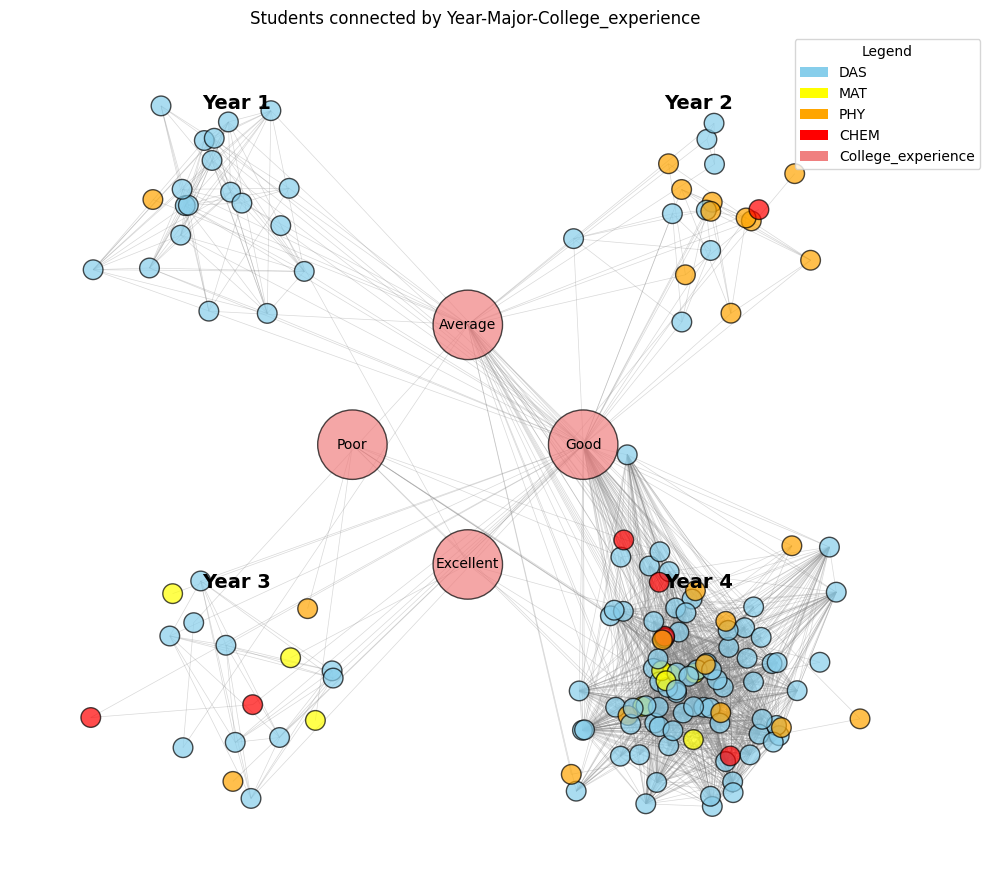

In [185]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major','College_experience'])

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students only if same Year, same Major, same College_experience
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and \
       (df.loc[i, 'Major'] == df.loc[j, 'Major']) and \
       (df.loc[i, 'College_experience'] == df.loc[j, 'College_experience']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {1: (-3, 3), 2: (3, 3), 3: (-3, -3), 4: (3, -3)}
coords = []

for idx, row in df.iterrows():
    year = row['Year_num']
    cx, cy = cluster_centers.get(year, (0,0))
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# College_experience nodes
# -------------------------------
experience_counts = df['College_experience'].value_counts().to_dict()
num_experience = len(experience_counts)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_experience, endpoint=False)
experience_pos = {}

for i, exp in enumerate(experience_counts.keys()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    experience_pos[exp] = (x, y)
    G.add_node(exp, type='experience')

# Connect students to their College_experience
for idx, row in df.iterrows():
    exp = str(row['College_experience']).strip()
    if exp in experience_counts:
        G.add_edge(idx, exp)

# Merge positions
pos.update(experience_pos)

# -------------------------------
# Node colors and sizes
# -------------------------------
node_colors = []
node_sizes = []

for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)
    elif G.nodes[n].get('type') == 'experience':
        node_colors.append('lightcoral')
        node_sizes.append(2500)

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='experience'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + \
                  [Patch(facecolor='lightcoral', label='College_experience')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Year-Major-College_experience")
plt.axis('off')
plt.tight_layout()
plt.show()

In [186]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
   Node    Degree  Betweenness  Closeness  Eigenvector  avg_centrality
0  Good  0.611842     0.273702   0.611842     0.151387        0.412193
1    76  0.296053     0.000000   0.403555     0.147297        0.211726
2    72  0.296053     0.000000   0.403555     0.147297        0.211726
3   137  0.296053     0.000000   0.403555     0.147297        0.211726
4    33  0.296053     0.000000   0.403555     0.147297        0.211726

Least important nodes (lowest centrality):
  Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0   88  0.006579          0.0   0.021531  4.769832e-16        0.007028
1  134  0.006579          0.0   0.021531  4.769832e-16        0.007028
2  117  0.006579          0.0   0.021531  4.769832e-16        0.007028
3   14  0.006579          0.0   0.021531  4.769832e-16        0.007028
4   55  0.013158          0.0   0.023684  7.606703e-16        0.009211


In [187]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")


--- Degree Centrality ---
Highest: Node=Good, Value=0.6118
Lowest: Node=14, Value=0.0066

--- Betweenness Centrality ---
Highest: Node=Good, Value=0.2737
Lowest: Node=0, Value=0.0000

--- Closeness Centrality ---
Highest: Node=Good, Value=0.6118
Lowest: Node=14, Value=0.0215

--- Eigenvector Centrality ---
Highest: Node=Good, Value=0.1514
Lowest: Node=14, Value=0.0000


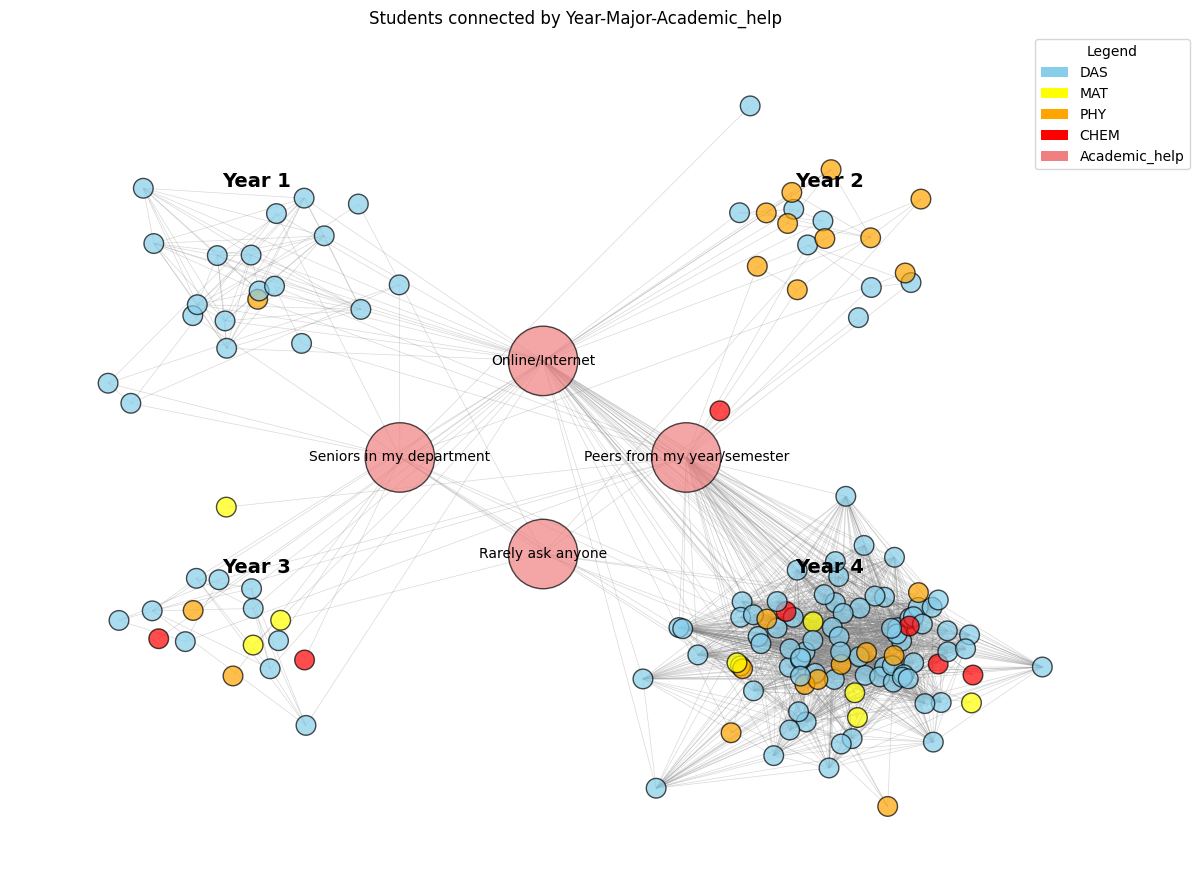

In [188]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major','Academic_help'])

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students only if same Year, same Major, same Academic_help
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and \
       (df.loc[i, 'Major'] == df.loc[j, 'Major']) and \
       (df.loc[i, 'Academic_help'] == df.loc[j, 'Academic_help']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {1: (-3, 3), 2: (3, 3), 3: (-3, -3), 4: (3, -3)}
coords = []

for idx, row in df.iterrows():
    year = row['Year_num']
    cx, cy = cluster_centers.get(year, (0,0))
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Academic_help nodes
# -------------------------------
help_counts = df['Academic_help'].value_counts().to_dict()
num_help = len(help_counts)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_help, endpoint=False)
help_pos = {}

for i, help_type in enumerate(help_counts.keys()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    help_pos[help_type] = (x, y)
    G.add_node(help_type, type='help')

# Connect students to their Academic_help
for idx, row in df.iterrows():
    help_type = str(row['Academic_help']).strip()
    if help_type in help_counts:
        G.add_edge(idx, help_type)

# Merge positions
pos.update(help_pos)

# -------------------------------
# Node colors and sizes
# -------------------------------
node_colors = []
node_sizes = []

for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)
    elif G.nodes[n].get('type') == 'help':
        node_colors.append('lightcoral')
        node_sizes.append(2500)

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='help'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + \
                  [Patch(facecolor='lightcoral', label='Academic_help')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Year-Major-Academic_help")
plt.axis('off')
plt.tight_layout()
plt.show()

In [189]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
                          Node    Degree  Betweenness  Closeness  Eigenvector  \
0  Peers from my year/semester  0.414474     0.109620   0.414474     0.165341   
1              Online/Internet  0.414474     0.124521   0.414474     0.000019   
2                            0  0.243421     0.000000   0.293391     0.162087   
3                           44  0.243421     0.000000   0.293391     0.162087   
4                           27  0.243421     0.000000   0.293391     0.162087   

   avg_centrality  
0        0.275977  
1        0.238372  
2        0.174725  
3        0.174725  
4        0.174725  

Least important nodes (lowest centrality):
  Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0  134  0.006579          0.0   0.031347  2.016886e-40        0.009481
1   48  0.006579          0.0   0.031347  2.016886e-40        0.009481
2   67  0.006579          0.0   0.031347  2.016886e-40        0.009481
3   43  0.013158      

In [190]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")


--- Degree Centrality ---
Highest: Node=Peers from my year/semester, Value=0.4145
Lowest: Node=21, Value=0.0066

--- Betweenness Centrality ---
Highest: Node=Online/Internet, Value=0.1245
Lowest: Node=0, Value=0.0000

--- Closeness Centrality ---
Highest: Node=Peers from my year/semester, Value=0.4145
Lowest: Node=48, Value=0.0313

--- Eigenvector Centrality ---
Highest: Node=Peers from my year/semester, Value=0.1653
Lowest: Node=48, Value=0.0000


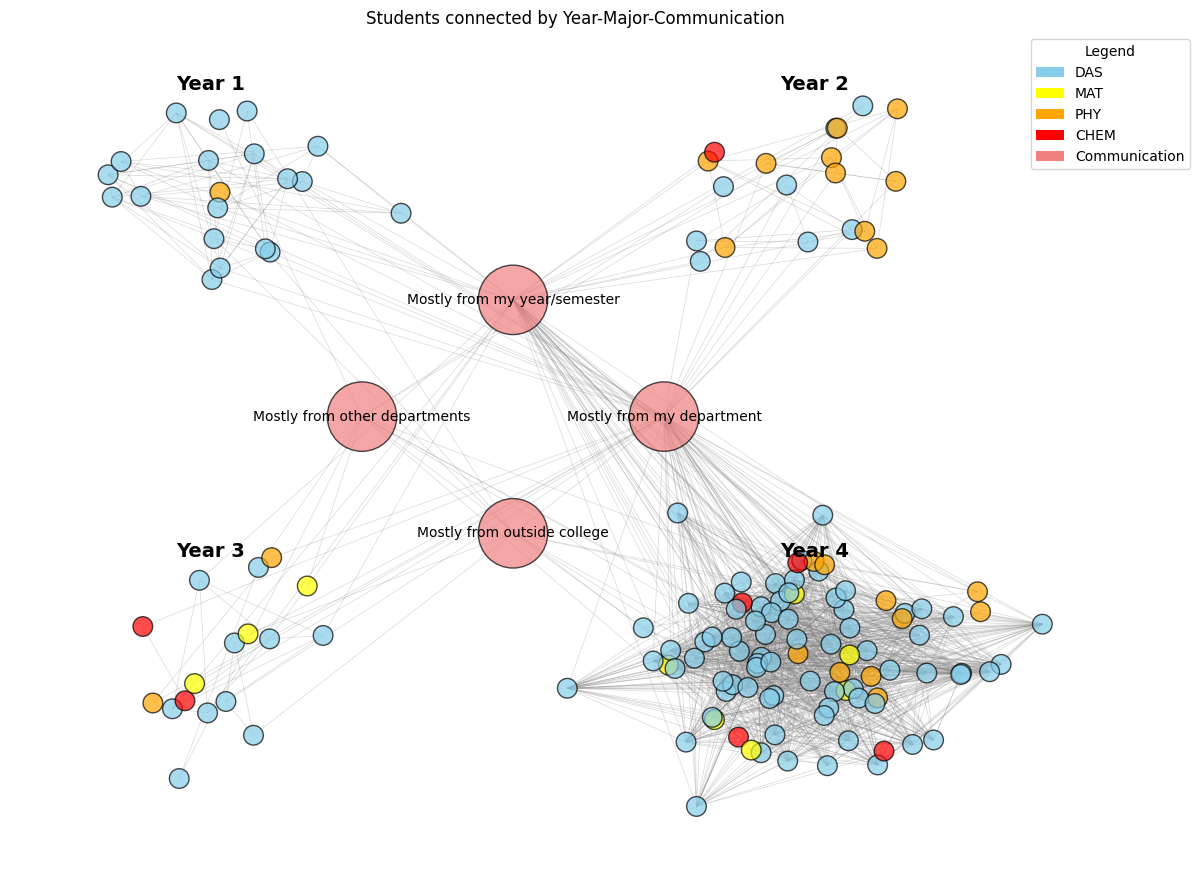

In [191]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major','Communication'])

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students only if same Year, same Major, same Communication
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and \
       (df.loc[i, 'Major'] == df.loc[j, 'Major']) and \
       (df.loc[i, 'Communication'] == df.loc[j, 'Communication']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {1: (-3, 3), 2: (3, 3), 3: (-3, -3), 4: (3, -3)}
coords = []

for idx, row in df.iterrows():
    year = row['Year_num']
    cx, cy = cluster_centers.get(year, (0,0))
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Communication nodes
# -------------------------------
comm_counts = df['Communication'].value_counts().to_dict()
num_comm = len(comm_counts)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_comm, endpoint=False)
comm_pos = {}

for i, comm_type in enumerate(comm_counts.keys()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    comm_pos[comm_type] = (x, y)
    G.add_node(comm_type, type='communication')

# Connect students to their Communication type
for idx, row in df.iterrows():
    comm_type = str(row['Communication']).strip()
    if comm_type in comm_counts:
        G.add_edge(idx, comm_type)

# Merge positions
pos.update(comm_pos)

# -------------------------------
# Node colors and sizes
# -------------------------------
node_colors = []
node_sizes = []

for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)
    elif G.nodes[n].get('type') == 'communication':
        node_colors.append('lightcoral')
        node_sizes.append(2500)

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='communication'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + \
                  [Patch(facecolor='lightcoral', label='Communication')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Year-Major-Communication")
plt.axis('off')
plt.tight_layout()
plt.show()


In [192]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
                           Node    Degree  Betweenness  Closeness  \
0     Mostly from my department  0.473684     0.155891   0.473684   
1  Mostly from my year/semester  0.368421     0.099163   0.368421   
2                           114  0.250000     0.000000   0.321748   
3                            82  0.250000     0.000000   0.321748   
4                           115  0.250000     0.000000   0.321748   

   Eigenvector  avg_centrality  
0     0.164159        0.316854  
1     0.000012        0.209004  
2     0.159955        0.182926  
3     0.159955        0.182926  
4     0.159955        0.182926  

Least important nodes (lowest centrality):
  Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0  134  0.006579          0.0   0.031347  2.952523e-25        0.009481
1  136  0.006579          0.0   0.041190  1.814823e-27        0.011942
2   93  0.006579          0.0   0.041190  1.814823e-27        0.011942
3   39  0.006579

In [193]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")


--- Degree Centrality ---
Highest: Node=Mostly from my department, Value=0.4737
Lowest: Node=21, Value=0.0066

--- Betweenness Centrality ---
Highest: Node=Mostly from my department, Value=0.1559
Lowest: Node=0, Value=0.0000

--- Closeness Centrality ---
Highest: Node=Mostly from my department, Value=0.4737
Lowest: Node=134, Value=0.0313

--- Eigenvector Centrality ---
Highest: Node=Mostly from my department, Value=0.1642
Lowest: Node=39, Value=0.0000


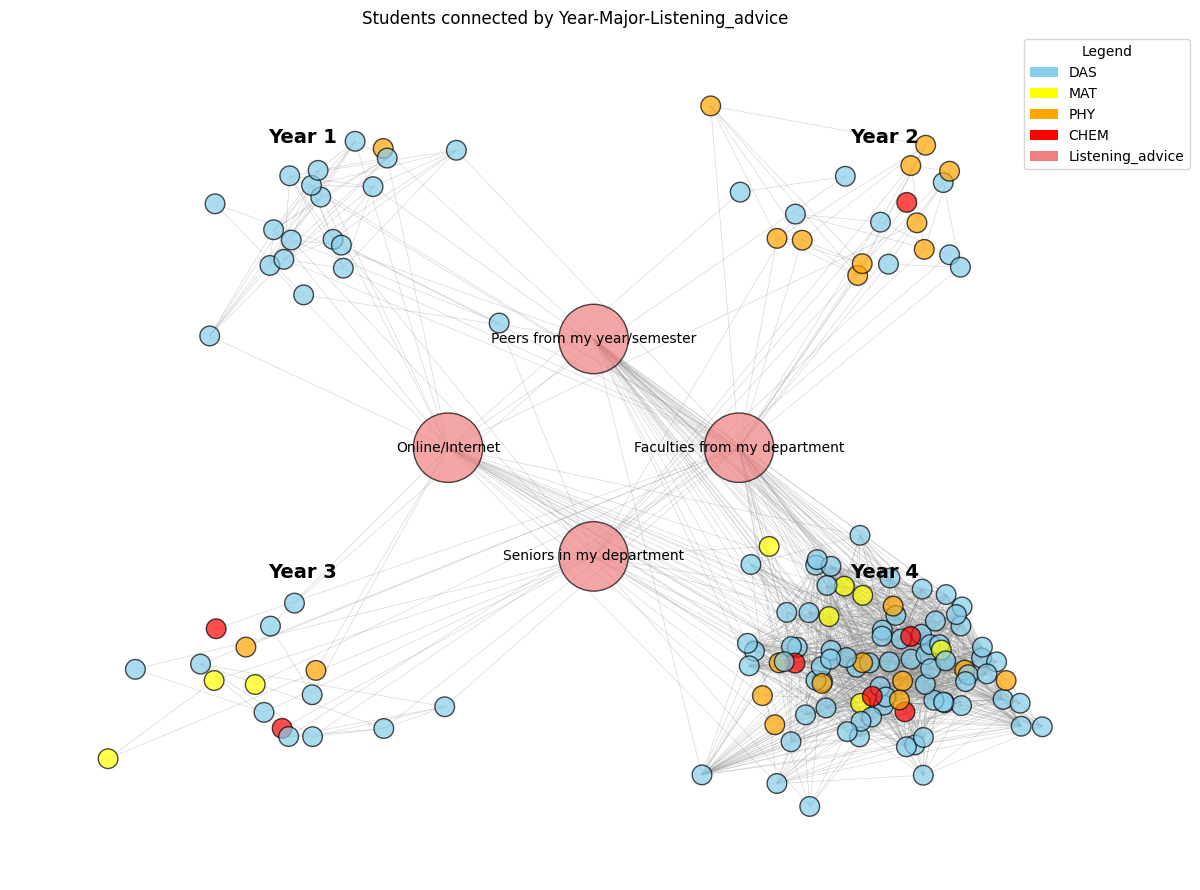

In [194]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
df = df.dropna(subset=['Year','Major','Listening_advice'])

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students only if same Year, same Major, same Listening_advice
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and \
       (df.loc[i, 'Major'] == df.loc[j, 'Major']) and \
       (df.loc[i, 'Listening_advice'] == df.loc[j, 'Listening_advice']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {1: (-3, 3), 2: (3, 3), 3: (-3, -3), 4: (3, -3)}
coords = []

for idx, row in df.iterrows():
    year = row['Year_num']
    cx, cy = cluster_centers.get(year, (0,0))
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Listening_advice nodes
# -------------------------------
advice_counts = df['Listening_advice'].value_counts().to_dict()
num_advice = len(advice_counts)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_advice, endpoint=False)
advice_pos = {}

for i, advice in enumerate(advice_counts.keys()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    advice_pos[advice] = (x, y)
    G.add_node(advice, type='listening_advice')

# Connect students to their Listening_advice
for idx, row in df.iterrows():
    advice = str(row['Listening_advice']).strip()
    if advice in advice_counts:
        G.add_edge(idx, advice)

# Merge positions
pos.update(advice_pos)

# -------------------------------
# Node colors and sizes
# -------------------------------
node_colors = []
node_sizes = []

for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)
    elif G.nodes[n].get('type') == 'listening_advice':
        node_colors.append('lightcoral')
        node_sizes.append(2500)

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='listening_advice'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + \
                  [Patch(facecolor='lightcoral', label='Listening_advice')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Year-Major-Listening_advice")
plt.axis('off')
plt.tight_layout()
plt.show()

In [195]:
# -------------------------------
# Compute centralities
# -------------------------------
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# -------------------------------
# Create centrality DataFrame
# -------------------------------
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
    'Degree': [degree_centrality[n] for n in G.nodes()],
    'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
    'Closeness': [closeness_centrality[n] for n in G.nodes()],
    'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
})

# Copy centrality_df
df_centrality = centrality_df.copy()

# Compute average centrality for ranking
df_centrality['avg_centrality'] = df_centrality[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)

# -------------------------------
# Most important nodes (highest centrality)
most_important = df_centrality.sort_values('avg_centrality', ascending=False).head(5)

# Least important nodes (lowest centrality)
least_important = df_centrality.sort_values('avg_centrality', ascending=True).head(5)

# Keep only relevant columns
cols = ['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']
most_important = most_important[cols].reset_index(drop=True)
least_important = least_important[cols].reset_index(drop=True)

print("Most important nodes (highest centrality):")
print(most_important)

print("\nLeast important nodes (lowest centrality):")
print(least_important)


Most important nodes (highest centrality):
                           Node    Degree  Betweenness  Closeness  \
0  Faculties from my department  0.328947     0.092105   0.328947   
1   Peers from my year/semester  0.269737     0.019432   0.269737   
2                             0  0.230263     0.000000   0.235302   
3                            75  0.230263     0.000000   0.235302   
4                            44  0.230263     0.000000   0.235302   

   Eigenvector  avg_centrality  
0     0.000002        0.187500  
1     0.167445        0.181588  
2     0.166632        0.158049  
3     0.166632        0.158049  
4     0.166632        0.158049  

Least important nodes (lowest centrality):
  Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
0   30  0.006579          0.0   0.077339  1.463219e-11        0.020980
1  133  0.006579          0.0   0.077339  1.463219e-11        0.020980
2   80  0.006579          0.0   0.077339  1.463219e-11        0.020980
3    2  0.013158

In [196]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")


--- Degree Centrality ---
Highest: Node=Faculties from my department, Value=0.3289
Lowest: Node=21, Value=0.0066

--- Betweenness Centrality ---
Highest: Node=Faculties from my department, Value=0.0921
Lowest: Node=0, Value=0.0000

--- Closeness Centrality ---
Highest: Node=Faculties from my department, Value=0.3289
Lowest: Node=30, Value=0.0773

--- Eigenvector Centrality ---
Highest: Node=Peers from my year/semester, Value=0.1674
Lowest: Node=30, Value=0.0000


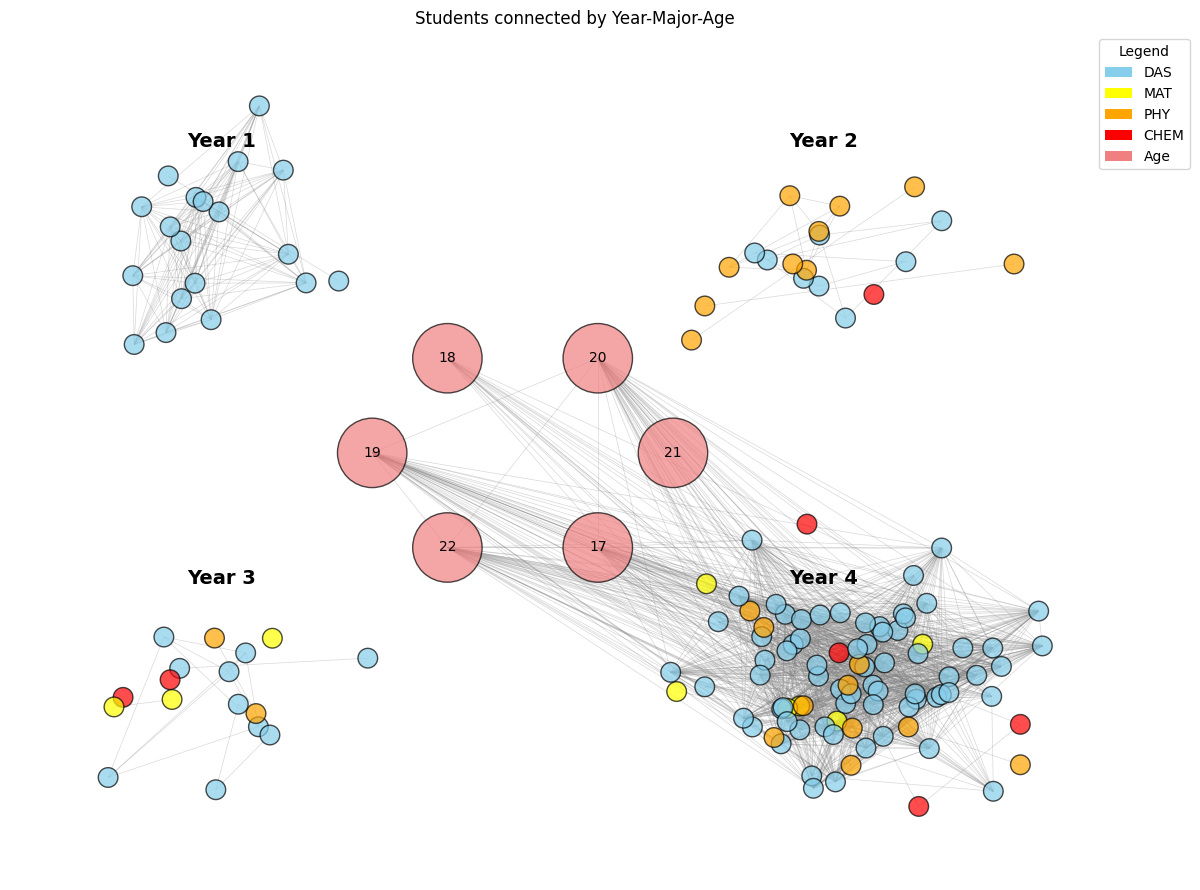

In [3]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv(r"C:\Users\Gadha Suresh\Downloads\preprocessed.csv")
df = df.dropna(subset=['Year','Major','Age'])

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Create graph: one node per student
# -------------------------------
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')

# Connect students only if same Year, same Major, same Age
for i, j in itertools.combinations(df.index, 2):
    if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and \
       (df.loc[i, 'Major'] == df.loc[j, 'Major']) and \
       (df.loc[i, 'Age'] == df.loc[j, 'Age']):
        G.add_edge(i, j)

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {1: (-3, 3), 2: (3, 3), 3: (-3, -3), 4: (3, -3)}
coords = []

for idx, row in df.iterrows():
    year = row['Year_num']
    cx, cy = cluster_centers.get(year, (0,0))
    x = np.random.normal(cx, 0.8)
    y = np.random.normal(cy, 0.8)
    coords.append((x,y))

coords = np.array(coords)
pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}

# -------------------------------
# Age nodes
# -------------------------------
age_counts = df['Age'].value_counts().to_dict()
num_age = len(age_counts)
radius = 1.5
angles = np.linspace(0, 2*np.pi, num_age, endpoint=False)
age_pos = {}

for i, age in enumerate(age_counts.keys()):
    x = radius * np.cos(angles[i])
    y = radius * np.sin(angles[i])
    age_pos[age] = (x, y)
    G.add_node(age, type='age')

# Connect students to their Age
for idx, row in df.iterrows():
    age = str(row['Age']).strip()
    if age in age_counts:
        G.add_edge(idx, age)

# Merge positions
pos.update(age_pos)

# -------------------------------
# Node colors and sizes
# -------------------------------
node_colors = []
node_sizes = []

for n in G.nodes():
    if G.nodes[n].get('type') == 'student':
        major = G.nodes[n]['major']
        node_colors.append(color_map.get(major,'gray'))
        node_sizes.append(200)
    elif G.nodes[n].get('type') == 'age':
        node_colors.append('lightcoral')
        node_sizes.append(2500)

# -------------------------------
# Plot network
# -------------------------------
plt.figure(figsize=(12,9))

nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7)
nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='age'}, font_size=10)

# annotate Year clusters
for year, (cx,cy) in cluster_centers.items():
    plt.text(cx, cy+1.2, f"Year {year}", fontsize=14, ha='center', fontweight='bold')

# legend
legend_elements = [Patch(facecolor=color_map[m], label=m) for m in majors] + \
                  [Patch(facecolor='lightcoral', label='Age')]
plt.legend(handles=legend_elements, title="Legend", bbox_to_anchor=(1.05, 1))

plt.title("Students connected by Year-Major-Age")
plt.axis('off')
plt.tight_layout()
plt.show()


In [7]:
centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']

for cent in centralities:
    max_node = centrality_df.loc[centrality_df[cent].idxmax()]
    min_node = centrality_df.loc[centrality_df[cent].idxmin()]
    
    print(f"\n--- {cent} Centrality ---")
    print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
    print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")


--- Degree Centrality ---
Highest: Node=7, Value=0.3108
Lowest: Node=21, Value=0.0000

--- Betweenness Centrality ---
Highest: Node=0, Value=0.0000
Lowest: Node=0, Value=0.0000

--- Closeness Centrality ---
Highest: Node=7, Value=0.3108
Lowest: Node=21, Value=0.0000

--- Eigenvector Centrality ---
Highest: Node=7, Value=0.1459
Lowest: Node=21, Value=0.0000



=== Avg_free_slots_per_week Column ===
Most important nodes (highest avg centrality):
    Node    Degree  Betweenness  Closeness  Eigenvector  avg_centrality
5      5  0.459459     0.336643   0.511876     0.195619        0.375899
6      6  0.277027     0.176595   0.399808     0.016014        0.217361
74    74  0.195946     0.000000   0.332845     0.181623        0.177603
57    57  0.195946     0.000000   0.332845     0.181623        0.177603
35    35  0.195946     0.000000   0.332845     0.181623        0.177603

Least important nodes (lowest avg centrality):
     Node    Degree  Betweenness  Closeness   Eigenvector  avg_centrality
98     98  0.006757          0.0   0.095068  6.200474e-11        0.025456
94     94  0.013514          0.0   0.096295  6.934665e-11        0.027452
91     91  0.013514          0.0   0.096295  6.934665e-11        0.027452
142   142  0.020270          0.0   0.100849  7.836096e-11        0.030280
141   141  0.020270          0.0   0.100849  7.836096e-11      

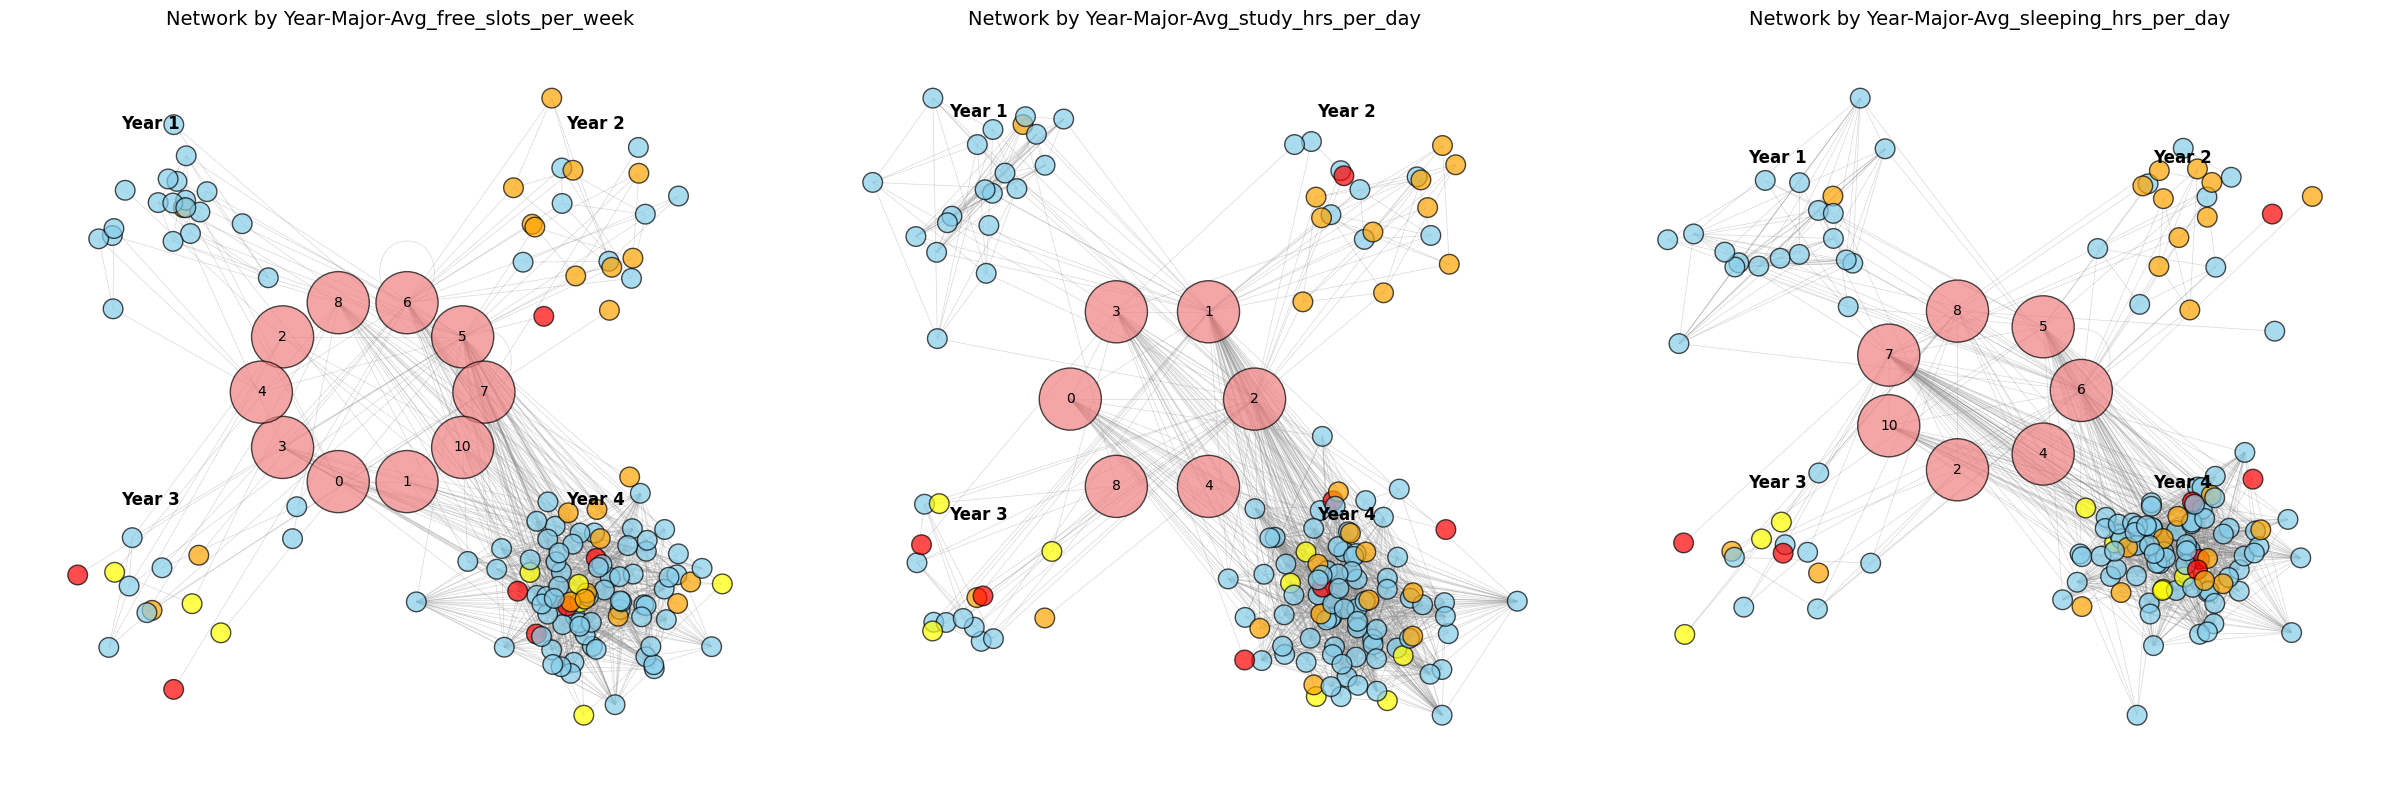

In [197]:
# -------------------------------
# Load data
# -------------------------------
df = pd.read_csv('preprocessed.csv')
columns_to_plot = ['Avg_free_slots_per_week', 'Avg_study_hrs_per_day', 'Avg_sleeping_hrs_per_day']

# extract numeric year (1,2,3,4) from column
def extract_year(y):
    match = re.search(r'\d+', str(y))
    return int(match.group()) if match else None

df['Year_num'] = df['Year'].apply(extract_year)
df = df.dropna(subset=['Year_num'])

# -------------------------------
# Colors for majors
# -------------------------------
majors = df['Major'].unique()
my_colors = ['skyblue', 'yellow', 'orange', 'red']
color_map = {m: my_colors[i % len(my_colors)] for i, m in enumerate(majors)}

# -------------------------------
# Coordinates for year clusters
# -------------------------------
cluster_centers = {1: (-3, 3), 2: (3, 3), 3: (-3, -3), 4: (3, -3)}

# -------------------------------
# Create subplots
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for ax_idx, col in enumerate(columns_to_plot):
    G = nx.Graph()
    
    # Add student nodes
    for idx, row in df.iterrows():
        G.add_node(idx, year=row['Year_num'], major=row['Major'], type='student')
    
    # Connect students: same Year, same Major, same column value
    for i, j in itertools.combinations(df.index, 2):
        if (df.loc[i, 'Year_num'] == df.loc[j, 'Year_num']) and \
           (df.loc[i, 'Major'] == df.loc[j, 'Major']) and \
           (df.loc[i, col] == df.loc[j, col]):
            G.add_edge(i, j)
    
    # Column central nodes
    unique_values = df[col].dropna().unique()
    num_values = len(unique_values)
    radius = 1.5
    angles = np.linspace(0, 2*np.pi, num_values, endpoint=False)
    value_pos = {}
    for i, val in enumerate(unique_values):
        x = radius * np.cos(angles[i])
        y = radius * np.sin(angles[i])
        value_pos[val] = (x, y)
        G.add_node(val, type='central')
    
    # Connect students to their column value
    for idx, row in df.iterrows():
        val = row[col]
        if val in value_pos:
            G.add_edge(idx, val)
    
    # Positions for students: jitter around year clusters
    coords = []
    for idx, row in df.iterrows():
        year = row['Year_num']
        cx, cy = cluster_centers.get(year, (0,0))
        x = np.random.normal(cx, 0.8)
        y = np.random.normal(cy, 0.8)
        coords.append((x,y))
    coords = np.array(coords)
    pos = {idx: (coords[i,0], coords[i,1]) for i, idx in enumerate(df.index)}
    
    # Merge central node positions
    pos.update(value_pos)
    
    # Node colors and sizes
    node_colors = []
    node_sizes = []
    for n in G.nodes():
        if G.nodes[n].get('type') == 'student':
            node_colors.append(color_map.get(G.nodes[n]['major'], 'gray'))
            node_sizes.append(200)
        else:
            node_colors.append('lightcoral')
            node_sizes.append(2000)
    
    # Draw network
    ax = axes[ax_idx]
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3, width=0.5, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, edgecolors='k', alpha=0.7, ax=ax)
    nx.draw_networkx_labels(G, pos, labels={n:n for n in G.nodes() if G.nodes[n].get('type')=='central'}, font_size=10, ax=ax)
    
    # annotate Year clusters
    for year, (cx, cy) in cluster_centers.items():
        ax.text(cx, cy+1.2, f"Year {year}", fontsize=12, ha='center', fontweight='bold')
    
    ax.set_title(f"Network by Year-Major-{col}", fontsize=14)
    ax.axis('off')
    
    # -------------------------------
    # Compute centralities
    # -------------------------------
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
    
    # -------------------------------
    # Create centrality DataFrame
    # -------------------------------
    centrality_df = pd.DataFrame({
        'Node': list(G.nodes()),
        'Type': [G.nodes[n].get('type', 'unknown') for n in G.nodes()],
        'Degree': [degree_centrality[n] for n in G.nodes()],
        'Betweenness': [betweenness_centrality[n] for n in G.nodes()],
        'Closeness': [closeness_centrality[n] for n in G.nodes()],
        'Eigenvector': [eigenvector_centrality[n] for n in G.nodes()]
    })
    
    # Average centrality
    centrality_df['avg_centrality'] = centrality_df[['Degree','Betweenness','Closeness','Eigenvector']].mean(axis=1)
    
    # Most important nodes
    most_important = centrality_df.sort_values('avg_centrality', ascending=False).head(5)
    least_important = centrality_df.sort_values('avg_centrality', ascending=True).head(5)
    
    print(f"\n=== {col} Column ===")
    print("Most important nodes (highest avg centrality):")
    print(most_important[['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']])
    
    print("\nLeast important nodes (lowest avg centrality):")
    print(least_important[['Node','Degree','Betweenness','Closeness','Eigenvector','avg_centrality']])
    
    # Individual max/min per centrality
    centralities = ['Degree', 'Betweenness', 'Closeness', 'Eigenvector']
    for cent in centralities:
        max_node = centrality_df.loc[centrality_df[cent].idxmax()]
        min_node = centrality_df.loc[centrality_df[cent].idxmin()]
        print(f"\n--- {cent} Centrality ---")
        print(f"Highest: Node={max_node['Node']}, Value={max_node[cent]:.4f}")
        print(f"Lowest: Node={min_node['Node']}, Value={min_node[cent]:.4f}")

plt.tight_layout()
plt.show()
